In [73]:
def split_pool(pool):
    pool_size = len(pool)
    split_1 = pool[0:int(pool_size/2)]
    split_2 = pool[int(pool_size/2):]
    print(len(split_1), len(split_2))
    return(split_1, split_2)

def run_test(samples, pool_dictionary):
    pool_result = 0
    false_positive = 0
    false_negative = 0
    for ID in samples:
        if pool_dictionary[ID] == 1:
            if random.random() < false_negative_rate:
                false_negative = 1
            else:
                pool_result = 1
        else:
            if random.random() < false_positive_rate:
                pool_result = 1 
                false_positive = 1
        if pool_result == 1 and false_negative == 1:
            false_negative = 0 #silent false negative since some other sample tested positive in the pool
    return pool_result, false_negative, false_positive

30.102999566398122  necessary binary divisions per positive case
split size 100
average multiplicity 1.0
initial queue size 1
50 50
25 25
12 13
total positive IDs:  0
true positives:  0
number of tests:  6
number of samples:  100
false positives:  0
false negatives:  0
30.102999566398122  necessary binary divisions per positive case
split size 100
average multiplicity 4.0
initial queue size 4
50 50
50 50
50 50
50 50
25 25
25 25
25 25
25 25
25 25
12 13
12 13
12 13
12 13
12 13
6 6
3 3
1 2
1 1
total positive IDs:  2
true positives:  4
number of tests:  37
number of samples:  400
false positives:  0
false negatives:  0
30.102999566398122  necessary binary divisions per positive case
split size 100
average multiplicity 9.0
initial queue size 9
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
6 6
6 6
6 6
6 6
6 6
6 7
6 6
6 7
3 3
3 3
3 3
3 3
3 3
3 3
3 3
1 2
1 2
1 2
1 2
1

3 3
3 3
3 3
3 3
3 3
3 3
3 4
3 3
3 4
3 3
3 3
3 3
3 4
3 4
3 4
3 3
3 3
3 3
3 3
3 4
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 4
3 4
3 4
3 3
3 3
3 4
3 3
3 3
3 4
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 4
1 2
2 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
2 2
1 2
2 2
1 2
1 2
1 2
1 2
2 2
1 2
1 2
2 2
1 2
1 2
1 2
2 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
2 2
1 2
1 2
1 2
1 2
2 2
2 2
2 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
2 2
2 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
total positive IDs:  121
true positives:  103
number of tests:  1461
number of samples:  10000
false positives:  11
false negatives:  1
30.102999566398122  necessary binary divisions per positive case
split size 100
average multiplicity 121.0
initial queue size 121
50 50


50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 25
25 2

12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 13
12 1

total positive IDs:  253
true positives:  213
number of tests:  3100
number of samples:  22500
false positives:  26
false negatives:  2
30.102999566398122  necessary binary divisions per positive case
split size 100
average multiplicity 256.0
initial queue size 256
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50

30.102999566398122  necessary binary divisions per positive case
split size 100
average multiplicity 289.0
initial queue size 289
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50


30.102999566398122  necessary binary divisions per positive case
split size 100
average multiplicity 324.0
initial queue size 324
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50
50 50


1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
2 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
2 2
1 2
2 2
2 2
1 2
2 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
2 2
1 2
2 2
1 2
1 2
1 2
2 2
1 2
1 2
1 2
1 2
1 2
1 2
2 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
2 2
1 2
1 2
2 2
1 2
1 2
1 2
2 2
1 2
1 2
1 2
1 2
1 2
1 2
2 2
2 2
2 2
1 2
1 2
1 2
1 2
1 2
2 2
2 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
2 2
1 2
2 2
1 2
1 2
1 2
2 2
1 2
1 2
1 2
1 2
2 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
2 2
1 2
2 2
1 2
2 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
2 2
1 2
1 2
1 2
1 2
1 2
2 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
2 2
1 2
1 2
2 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
2 2
1 2
1 2
1 2
1 2
1 2
2 2
1 2
2 2
1 2
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


6 6
6 7
6 7
6 6
6 7
6 7
6 6
6 6
6 7
6 6
6 7
6 7
6 6
6 6
6 6
6 7
6 6
6 7
6 6
6 7
6 6
6 6
6 7
6 6
6 7
6 6
6 7
6 7
6 6
6 7
6 7
6 7
6 6
6 6
6 7
6 6
6 7
6 7
6 6
6 7
6 7
6 7
6 6
6 7
6 7
6 7
6 7
6 6
6 7
6 7
6 7
6 7
6 6
6 6
3 3
3 3
3 3
3 4
3 3
3 4
3 3
3 3
3 4
3 4
3 4
3 3
3 3
3 3
3 4
3 3
3 4
3 4
3 4
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 4
3 4
3 3
3 3
3 3
3 3
3 4
3 4
3 3
3 3
3 3
3 3
3 3
3 4
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 4
3 3
3 4
3 3
3 4
3 3
3 4
3 3
3 3
3 3
3 3
3 3
3 4
3 3
3 3
3 3
3 4
3 4
3 4
3 3
3 3
3 3
3 3
3 3
3 4
3 3
3 3
3 4
3 3
3 3
3 3
3 4
3 3
3 3
3 4
3 3
3 3
3 3
3 3
3 4
3 3
3 4
3 4
3 3
3 4
3 4
3 4
3 4
3 4
3 3
3 3
3 3
3 4
3 3
3 3
3 4
3 3
3 3
3 3
3 3
3 3
3 3
3 4
3 3
3 3
3 4
3 3
3 4
3 3
3 4
3 4
3 3
3 3
3 4
3 3
3 4
3 4
3 3
3 3
3 3
3 3
3 3
3 4
3 3
3 4
3 3
3 3
3 4
3 3
3 3
3 4
3 3
3 3
3 4
3 3
3 3
3 4
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 4
3 3
3 3
3 3
3 4
3 4
3 3
3 4
3 3
3 3
3 4
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 4
3 3
3 4
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 4
3 4


5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3


5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
2 3
2 3
2 3
2 3
2 3


6.020599913279623  necessary binary divisions per positive case
split size 10
average multiplicity 1000.0
initial queue size 1000
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 

5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5


1 2
1 2
1 2
1 1
1 2
1 1
1 2
1 1
1 2
1 2
1 2
1 2
1 1
1 2
1 2
1 2
1 2
1 1
1 2
1 1
1 2
1 2
1 1
1 2
1 2
1 2
1 1
1 2
1 1
1 1
1 2
1 1
1 1
1 1
1 2
1 1
1 2
1 2
1 2
1 1
1 1
1 1
1 1
1 2
1 2
1 2
1 2
1 1
1 1
1 1
1 2
1 1
1 2
1 1
1 2
1 1
1 1
1 2
1 1
1 2
1 1
1 2
1 1
1 2
1 2
1 1
1 2
1 1
1 2
1 1
1 2
1 1
1 1
1 2
1 2
1 1
1 2
1 1
1 1
1 1
1 2
1 1
1 2
1 1
1 2
1 2
1 2
1 2
1 1
1 1
1 2
1 2
1 2
1 1
1 2
1 2
1 2
1 1
1 2
1 2
1 1
1 1
1 1
1 2
1 1
1 2
1 2
1 2
1 1
1 2
1 1
1 2
1 2
1 2
1 2
1 1
1 2
1 1
1 2
1 2
1 1
1 1
1 2
1 2
1 1
1 1
1 2
1 1
1 1
1 2
1 2
1 2
1 1
1 2
1 2
1 2
1 1
1 2
1 1
1 2
1 2
1 1
1 1
1 2
1 2
1 2
1 2
1 2
1 1
1 2
1 1
1 1
1 1
1 2
1 2
1 2
1 1
1 2
1 1
1 2
1 2
1 2
1 1
1 2
1 1
1 2
1 1
1 1
1 2
1 1
1 1
1 2
1 1
1 2
1 2
1 1
1 2
1 1
1 2
1 2
1 2
1 1
1 1
1 2
1 2
1 1
1 1
1 1
1 2
1 1
1 2
1 2
1 2
1 2
1 1
1 1
1 1
1 1
1 2
1 1
1 1
1 2
1 1
1 1
1 2
1 2
1 2
1 1
1 1
1 1
1 2
1 1
1 2
1 1
1 2
1 2
1 2
1 1
1 2
1 2
1 2
1 2
1 2
1 2
1 1
1 2
1 2
1 2
1 1
1 2
1 2
1 2
1 1
1 2
1 2
1 1
1 2
1 1
1 2
1 2
1 2
1 2
1 1
1 2
1 1
1 2
1 2
1 2
1 1
1 1


2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
1 1
1 2
1 2
1 2
1 1
1 2
1 1
1 2
1 1
1 1
1 2
1 1
1 2
1 2
1 1
1 2
1 1
1 2
1 2
1 2
1 1
1 1
1 2
1 2
1 2
1 1
1 1
1 1
1 2
1 1
1 1
1 1
1 2
1 2
1 2
1 1
1 2
1 1
1 2
1 2
1 1
1 2
1 1
1 1
1 2
1 2
1 2
1 1
1 2
1 1
1 1
1 1
1 1
1 2
1 1
1 2
1 2
1 2
1 2
1 1
1 2
1 1
1 2
1 2
1 1
1 2
1 1
1 1
1 2
1 2
1 1
1 1
1 1
1 1
1 1
1 2
1 2
1 1
1 1
1 2
1 2
1 1
1 2
1 2
1 1
1 2
1 1
1 1
1 2
1 2
1 1
1 2
1 1
1 2
1 2
1 2
1 2
1 1
1 2
1 1
1 2
1 2
1 1
1 2
1 1
1 2
1 2
1 2
1 2
1 1
1 1
1 2
1 2
1 1
1 2
1 2
1 2
1 2
1 2
1 1
1 2
1 2
1 2
1 2
1 1
1 1
1 1
1 1
1 2
1 2
1 2
1 1
1 1
1 2
1 2
1 2
1 1
1 1
1 2
1 2
1 1


2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3


1 1
1 1
1 2
1 1
1 2
1 2
1 2
1 1
1 1
1 1
1 1
1 2
1 2
1 2
1 1
1 1
1 2
1 1
1 2
1 1
1 2
1 1
1 2
1 2
1 1
1 1
1 2
1 2
1 1
1 1
1 1
1 2
1 2
1 1
1 2
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3


1 2
1 1
1 1
1 1
1 2
1 2
1 1
1 2
1 1
1 2
1 1
1 2
1 1
1 2
1 1
1 2
1 2
1 1
1 1
1 1
1 1
1 2
1 1
1 2
1 1
1 2
1 2
1 1
1 2
1 1
1 1
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 1
1 1
1 2
1 2
1 2
1 1
1 1
1 1
1 1
1 2
1 2
1 1
1 2
1 1
1 2
1 1
1 2
1 1
1 2
1 1
1 2
1 1
1 1
1 2
1 1
1 1
1 2
1 1
1 1
1 2
1 2
1 1
1 1
1 2
1 2
1 2
1 1
1 2
1 2
1 2
1 1
1 2
1 2
1 1
1 2
1 2
1 2
1 2
1 2
1 2
1 1
1 1
1 1
1 2
1 2
1 2
1 2
1 2
1 1
1 2
1 2
1 1
1 2
1 1
1 2
1 2
1 2
1 1
1 2
1 2
1 2
1 1
1 1
1 2
1 2
1 1
1 2
1 2
1 2
1 1
1 2
1 2
1 2
1 2
1 1
1 2
1 2
1 1
1 2
1 2
1 1
1 2
1 2
1 1
1 1
1 1
1 2
1 2
1 1
1 2
1 1
1 2
1 2
1 2
1 2
1 2
1 2
1 1
1 1
1 2
1 1
1 2
1 2
1 1
1 2
1 2
1 2
1 1
1 2
1 1
1 2
1 2
1 1
1 2
1 1
1 2
1 1
1 2
1 2
1 1
1 2
1 2
1 1
1 2
1 2
1 1
1 2
1 2
1 2
1 2
1 1
1 2
1 2
1 2
1 1
1 2
1 2
1 2
1 1
1 1
1 2
1 2
1 2
1 1
1 1
1 1
1 2
1 1
1 1
1 2
1 1
1 2
1 2
1 2
1 2
1 2
1 2
1 1
1 2
1 2
1 2
1 2
1 2
1 2
1 1
1 2
1 1
1 1
1 2
1 1
1 2
1 2
1 1
1 1
1 2
1 2
1 1
1 2
1 2
1 1
1 2
1 1
1 1
1 2
1 1
1 2
1 2
1 2
1 2
1 2
1 1
1 1
1 1
1 1
1 2
1 2
1 2
1 2
1 1
1 2
1 2
1 2


5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3


1 2
1 1
1 1
1 1
1 1
1 2
1 2
1 2
1 2
1 1
1 2
1 2
1 2
1 1
1 2
1 2
1 2
1 1
1 1
1 2
1 2
1 2
1 2
1 1
1 2
1 2
1 2
1 2
1 2
1 1
1 1
1 2
1 2
1 1
1 2
1 1
1 1
1 1
1 1
1 2
1 1
1 2
1 1
1 2
1 1
1 2
1 1
1 1
1 2
1 2
1 2
1 2
1 2
1 2
1 1
1 2
1 2
1 2
1 1
1 1
1 2
1 1
1 1
1 2
1 1
1 2
1 2
1 2
1 2
1 1
1 2
1 1
1 2
1 2
1 1
1 2
1 2
1 1
1 1
1 1
1 2
1 2
1 2
1 2
1 2
1 2
1 1
1 2
1 2
1 1
1 2
1 1
1 1
1 2
1 1
1 2
1 2
1 1
1 2
1 2
1 1
1 1
1 2
1 1
1 2
1 1
1 2
1 1
1 1
1 2
1 1
1 1
1 1
1 1
1 1
1 2
1 2
1 1
1 2
1 2
1 2
1 1
1 2
1 2
1 2
1 2
1 1
1 2
1 1
1 2
1 2
1 1
1 2
1 2
1 1
1 2
1 2
1 2
1 1
1 2
1 2
1 2
1 2
1 1
1 1
1 2
1 1
1 2
1 1
1 2
1 1
1 2
1 1
1 2
1 1
1 2
1 2
1 1
1 2
1 2
1 2
1 2
1 1
1 2
1 1
1 1
1 2
1 1
1 2
1 2
1 2
1 1
1 2
1 1
1 1
1 1
1 2
1 2
1 1
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 1
1 2
1 2
1 1
1 2
1 1
1 2
1 1
1 1
1 2
1 1
1 2
1 2
1 2
1 1
1 1
1 1
1 2
1 2
1 1
1 1
1 2
1 1
1 2
1 2
1 2
1 2
1 1
1 2
1 1
1 2
1 1
1 1
1 2
1 1
1 2
1 1
1 1
1 1
1 2
1 2
1 2
1 2
1 1
1 2
1 1
1 2
1 2
1 1
1 2
1 1
1 1
1 1
1 2
1 2
1 1
1 2
1 2
1 1
1 2
1 2


5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5


2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
total positive IDs:  4026
true positives:  2870
number of tests:  18915
number of samples:  28900
false positives:  441
false negatives:  35
6.020599913279623  necessary binary divisions per positive case
split size 10
average multiplicity 3240.0
initial queue size 3240
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5

5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5


2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5


2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3


1 2
1 2
1 1
1 2
1 2
1 2
1 1
1 2
1 2
1 1
1 2
1 1
1 2
1 1
1 1
1 2
1 2
1 2
1 1
1 2
1 1
1 1
1 2
1 1
1 2
1 2
1 1
1 2
1 1
1 2
1 2
1 1
1 1
1 1
1 2
1 2
1 1
1 2
1 1
1 2
1 1
1 2
1 1
1 2
1 2
1 1
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 1
1 2
1 1
1 2
1 1
1 1
1 2
1 1
1 1
1 2
1 1
1 2
1 2
1 2
1 2
1 2
1 1
1 2
1 1
1 2
1 1
1 2
1 2
1 2
1 2
1 1
1 2
1 1
1 1
1 2
1 1
1 2
1 1
1 2
1 2
1 2
1 2
1 1
1 2
1 2
1 2
1 1
1 2
1 2
1 2
1 2
1 1
1 2
1 2
1 2
1 2
1 2
1 1
1 2
1 1
1 1
1 2
1 2
1 1
1 1
1 2
1 1
1 1
1 2
1 2
1 2
1 2
1 1
1 1
1 2
1 2
1 2
1 1
1 1
1 2
1 2
1 1
1 2
1 1
1 1
1 2
1 2
1 2
1 2
1 1
1 2
1 2
1 2
1 1
1 2
1 1
1 2
1 2
1 2
1 2
1 1
1 1
1 2
1 1
1 2
1 2
1 1
1 2
1 2
1 1
1 1
1 2
1 2
1 2
1 2
1 1
1 2
1 1
1 2
1 1
1 2
1 1
1 2
1 1
1 1
1 1
1 2
1 1
1 1
1 2
1 2
1 1
1 1
1 2
1 1
1 2
1 2
1 2
1 1
1 2
1 1
1 2
1 2
1 2
1 2
1 1
1 2
1 1
1 2
1 1
1 1
1 2
1 2
1 1
1 2
1 1
1 2
1 1
1 2
1 1
1 2
1 2
1 2
1 1
1 1
1 2
1 1
1 2
1 2
1 2
1 1
1 2
1 1
1 1
1 2
1 2
1 2
1 1
1 2
1 1
1 1
1 2
1 2
1 1
1 1
1 2
1 2
1 1
1 2
1 2
1 1
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 2
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


4.0  necessary binary divisions per positive case
split size 2
average multiplicity 3200.0
initial queue size 3200
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1

1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


4.0  necessary binary divisions per positive case
split size 2
average multiplicity 11250.0
initial queue size 11250
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1

1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


total positive IDs:  21785
true positives:  12691
number of tests:  37176
number of samples:  25600
false positives:  2485
false negatives:  195
4.0  necessary binary divisions per positive case
split size 2
average multiplicity 14450.0
initial queue size 14450
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 

1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


4.0  necessary binary divisions per positive case
split size 2
average multiplicity 16200.0
initial queue size 16200
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1

1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


4.0  necessary binary divisions per positive case
split size 2
average multiplicity 18050.0
initial queue size 18050
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1

1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


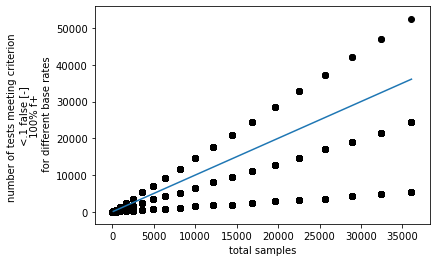

In [86]:
import numpy as np
import random
import matplotlib.pyplot as plt
import uuid
### initialize test pool ###

sizes = list(range(10,200,10))
false_negatives = np.zeros(len(sizes))
false_positives = np.zeros(len(sizes))
numbers_of_samples = np.zeros(len(sizes))
numbers_of_tests = np.zeros(len(sizes))
true_positive_rate = 0.01345

global false_negative_rate
false_negative_rate = 0.1

global false_positive_rate
false_positive_rate = 0.01345

for true_positive_rate in [0.01, 0.1, 0.5]:
    for condition in range(0, len(sizes)):
        patient_samples = sizes[condition]**2

        grand_test_pool = np.zeros((patient_samples))
        ids_grand_pool = np.zeros((patient_samples),uuid.UUID)
        pool_dictionary = {}


        true_positives = 0
        positive_patients= []
        # positive_patients = random.choices(range(0,patient_samples),k=int(true_positive_rate*patient_samples))
        for i in range(0,patient_samples):
            ID = uuid.uuid4()
            ids_grand_pool[i] = ID
            if random.random() <= true_positive_rate:
                true_positives += 1
                grand_test_pool[i] = 1
                pool_dictionary[ID] =1
                positive_patients.append(i)
            else:
                pool_dictionary[ID] =0

        #initial split
        guess_rate = true_positive_rate
        guess_average_multiplicity = patient_samples*guess_rate
        shannon_information = guess_rate * np.log2(guess_rate) 
        print(-2/shannon_information, " necessary binary divisions per positive case")


        main_queue = []
        split_size = int(1/guess_rate)
        for multiple in range(0, int(guess_average_multiplicity)):
            main_queue.append(ids_grand_pool[split_size*multiple:split_size*multiple+split_size])

        print("split size", split_size)
        print("average multiplicity", guess_average_multiplicity)
        print("initial queue size", len(main_queue))


        total_false_negatives, total_false_positives = 0,0
        MASTER_TEST_COUNTER = 0
        POSITIVE_IDS = 0
        while len(main_queue) > 0:

            if len(main_queue[0]) > 1:
                pool_a, pool_b = split_pool(main_queue[0])    


                MASTER_TEST_COUNTER += 1
                main_queue.remove(main_queue[0])
                A, afalse_positive, afalse_negative = run_test(pool_a, pool_dictionary)
                if A == 1:
                    main_queue.append(pool_a)
                    if len(pool_a) == 1:
                        POSITIVE_IDS += 1
                        total_false_negatives += afalse_negative
                        total_false_positives += afalse_positive
                else:
                    if len(pool_a) == 1:
                        total_false_negatives += afalse_negative
                        total_false_positives += afalse_positive


                MASTER_TEST_COUNTER += 1
                B, bfalse_positive, bfalse_negative = run_test(pool_b, pool_dictionary)
                if B == 1:
                    main_queue.append(pool_b)
                    if len(pool_b) == 1:
                        POSITIVE_IDS += 1
                        total_false_negatives += bfalse_negative
                        total_false_positives += bfalse_positive
                else:
                    if len(pool_b) == 1:
                        total_false_negatives += bfalse_negative
                        total_false_positives += bfalse_positive

            
            else:
                MASTER_TEST_COUNTER += 1
                C, cfalse_positive, cfalse_negative = run_test(main_queue[0], pool_dictionary)
                total_false_negatives += cfalse_negative
                total_false_positives += cfalse_positive
                if C == 1:
                    POSITIVE_IDS += 1
    #                 print("+")
                main_queue.remove(main_queue[0])
        print("total positive IDs: ", POSITIVE_IDS)        
        print("true positives: ", true_positives)
        print("number of tests: ", MASTER_TEST_COUNTER)
        print("number of samples: ", patient_samples)
        print("false positives: ", total_false_positives)
        print("false negatives: ", total_false_negatives)

        false_negatives[condition] = total_false_negatives
        false_positives[condition] = total_false_positives
        numbers_of_samples[condition] = patient_samples
        numbers_of_tests[condition] = MASTER_TEST_COUNTER
        plt.scatter(numbers_of_samples, numbers_of_tests, c="k")
plt.plot(numbers_of_samples,numbers_of_samples)        
plt.xlabel("total samples")
plt.ylabel("number of tests meeting criterion \n <.1 false [-] \n 100% f+ \n for different base rates" )
plt.show()
plt.close()